# Qiskit v2.0 — Ep. 9: Constructing Circuits Programmatically

Learn how to generate circuits from Python code:
- Add quantum & classical registers
- Append gates in loops
- Use parameters for reusable blocks
- Combine subcircuits
- Simulate & visualize results

## 1) Adding registers
A circuit is built from **quantum** registers (qubits) and **classical** registers (bits for measurement).

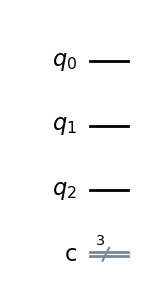

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3, 3)  # 3 qubits, 3 classical bits
qc.draw("mpl")

## 2) Adding gates dynamically
You can construct circuits by appending gates manually *and* in loops.

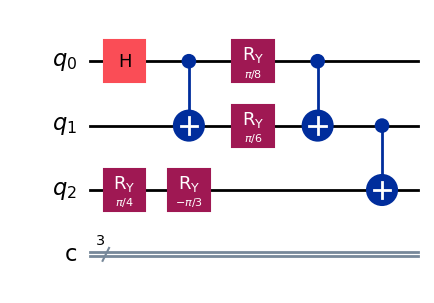

In [2]:
from qiskit.circuit.library import RYGate
from math import pi

n = 3
qc = QuantumCircuit(n, n)

# Manual steps
qc.h(0)          # Hadamard on q0
qc.cx(0, 1)      # CNOT q0 -> q1
qc.ry(pi/4, 2)   # RY on q2

# Dynamic rotations: one angle per qubit
thetas = [pi/8, pi/6, -pi/3]
for q, theta in enumerate(thetas):
    qc.append(RYGate(theta), [q])

# Daisy‑chain CNOTs
for q in range(n - 1):
    qc.cx(q, q + 1)

qc.draw("mpl")

## 3) Parameterization
Use `Parameter` to make templates you can bind with values later (essential for variational algorithms).

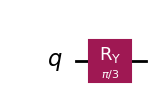

In [3]:
from qiskit.circuit import Parameter

theta = Parameter("θ")
pqc = QuantumCircuit(1)
pqc.ry(theta, 0)

# Assign a concrete angle later
bound = pqc.assign_parameters({theta: pi/3})
bound.draw("mpl")

## 4) Programmatic patterns (loop example)
Generate a repeated structure with Python control flow.

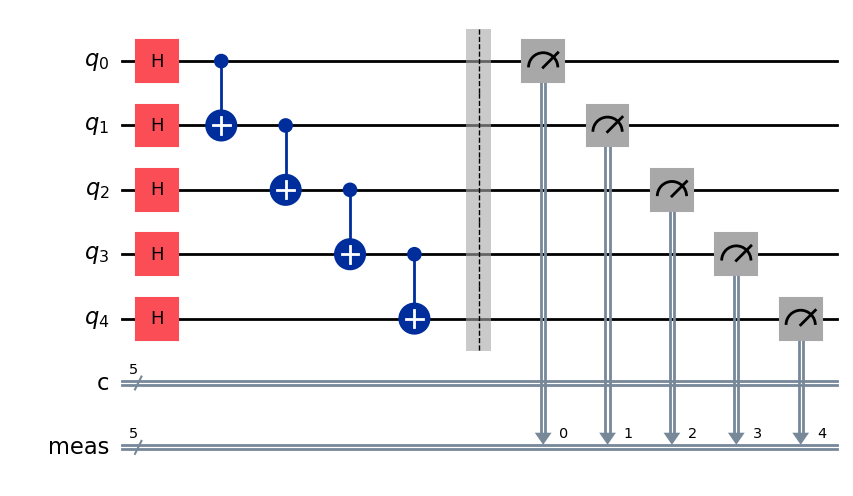

In [4]:
m = 5
qc = QuantumCircuit(m, m)

# Hadamard on all qubits
for q in range(m):
    qc.h(q)

# Chain CNOTs: 0->1->2->3->4
for c in range(m - 1):
    qc.cx(c, c + 1)

qc.measure_all()
qc.draw("mpl")

## 5) Combining subcircuits
Package a useful block once and reuse it anywhere.

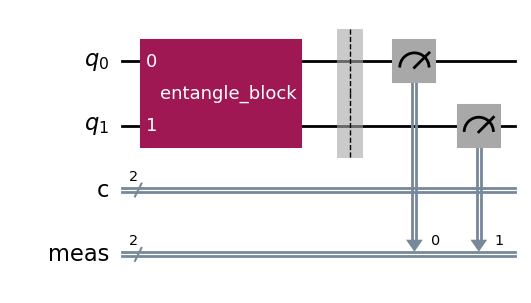

In [5]:
from qiskit.circuit.library import HGate, CXGate

# Define a 2‑qubit subcircuit
sub = QuantumCircuit(2, name="entangle_block")
sub.append(HGate(), [0])
sub.append(CXGate(), [0, 1])

# Use it in another circuit
host = QuantumCircuit(2, 2)
host.append(sub.to_instruction(), [0, 1])
host.measure_all()
host.draw("mpl")

## 6) Visualizing results (simulate)
Run on Aer to view a measurement histogram.

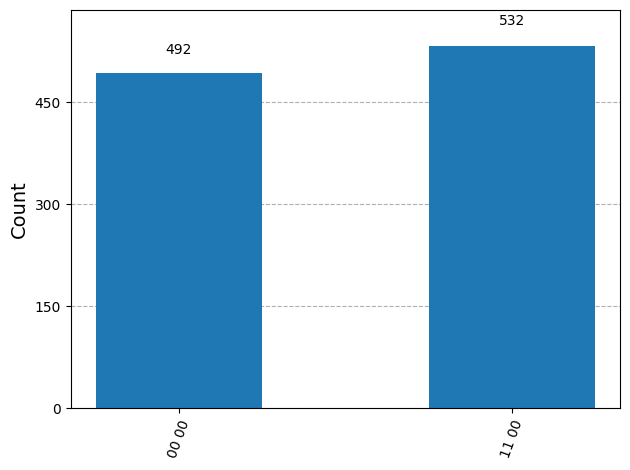

In [6]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

sim = AerSimulator()
t_host = transpile(host, sim)
result = sim.run(t_host, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)

---
## 7) Mini‑challenge — Ladder entangler (with parameters)

**Task.** Write a function `ladder(n)` that:
1. Creates an `n`‑qubit circuit.
2. Applies `RY(θ_i)` to each qubit with independent parameters `θ_i`.
3. Adds a CNOT chain `0→1→2→…→n-1`.
4. Returns both the template circuit and the list of parameters.

Then **bind** the parameters to specific values (e.g., `[π/8, π/6, …]`) and simulate to get a histogram.

> Hint: store parameters in a Python list so you can bind them with a dict like `{theta_list[i]: value}`.

> Try using `seed_simulator` and `seed_transpiler` to ensure reproducibility.

In [ ]:
# Your solution here
from math import pi

def ladder(n: int):
    ...

# Example usage (after you implement ladder):
# tmpl, thetas = ladder(4)
# values = [pi/8, pi/6, pi/5, pi/4]
# bound = tmpl.assign_parameters({p: v for p, v in zip(thetas, values)})
# sim = AerSimulator(); res = sim.run(transpile(bound, sim), shots=1024).result()
# plot_histogram(res.get_counts())


<details>
<summary><strong>Show reference solution</strong></summary>

```python
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import pi

def ladder(n: int) -> tuple:
    """
    Create a ladder circuit with n rY rotations.

    Parameters:
    -----------
    n : int
        The number of qubits (and rY rotations) in the circuit.

    Returns:
    --------
    qc : QuantumCircuit
        The constructed ladder circuit.
    thetas : list
        The list of parameters corresponding to the rY rotations.
    """
    qc = QuantumCircuit(n)
    thetas = [Parameter(f"θ{i}") for i in range(n)]
    for q, th in enumerate(thetas):
        qc.ry(th, q)
    for q in range(n - 1):
        qc.cx(q, q + 1)
    return qc, thetas

# Parametrized template
tmpl, params = ladder(4)

# Assign numerical parameters
vals = [pi/8, pi/6, pi/5, pi/4]
bound = tmpl.assign_parameters({p: v for p, v in zip(params, vals)})

# Add measurements
meas = bound.copy()
meas.measure_all()

# Simulate and plot
sim = AerSimulator(seed_simulator=128)
tqc = transpile(meas, sim, seed_transpiler=128)
res = sim.run(tqc, shots=1024).result()
plot_histogram(res.get_counts())

```

The expected circuit has the following form:
![Expected circuit](assets/ladder%20entangler.png)

</details>

---
## 8) Summary
- Programmatic construction lets you **scale** designs, **reuse** components, and **parameterize** for optimization.
- Subcircuits keep code clean and modular.
- Simulators bridge design with quick feedback before targeting hardware.